In [1]:
# Copyright (c) 2024 Graphcore Ltd. All rights reserved.

# Energy Minimisation

A central problem of electronic structure simulations is finding the ground state 
configuration of many interacting electrons.  Within MESS this is handled by:

* building a `Hamiltonian` by selecting how to model the quantum-mechanical interactions
  with the `xc_method` argument.
* minimisation of the total energy subject to the constraint of orthonormal orbitals.


On the second point, there are many possible approaches to the constrained optimisation
problem.  In the following we setup solving this minimisation with the 
[optax library](https://optax.readthedocs.io/en/latest/index.html).

In [2]:
import jax
import optax
import jax.numpy as jnp
from mess import basisset, Hamiltonian, molecule
from mess.structure import nuclear_energy
from tqdm import tqdm
import seaborn as sns

sns.set_theme(style="whitegrid")

mol = molecule("water")
basis = basisset(mol, "6-31g")
H = Hamiltonian(basis, xc_method="lda")
optimiser = optax.adam(learning_rate=0.1)

/home/ubuntu/miniforge3/envs/jax/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Next we define a function that evaluates the total energy given an arbitrary matrix $Z$
which applies the orthonormal constraint.  This efffectively converts the minimisation 
problem into an unconstrained optimisation one.

In [3]:
E_n = nuclear_energy(mol)


@jax.jit
def total_energy(Z):
    C = H.orthonormalise(Z)
    P = basis.density_matrix(C)
    return H(P) + E_n

We use a somewhat arbitrary initial guess and use the Adam optimiser to minimise
the total energy

In [4]:
Z = jnp.eye(basis.num_orbitals)
state = optimiser.init(Z)
history = []

for _ in (bar := tqdm(range(128))):
    e, grads = jax.value_and_grad(total_energy)(Z)
    updates, state = optimiser.update(grads, state)
    Z = optax.apply_updates(Z, updates)
    history.append(e)
    bar.set_description(f"Total energy: {e:0.06f} (Hartree)")

Total energy: -76.014274 (Hartree): 100%|██████████| 128/128 [00:02<00:00, 55.51it/s] 


Next we can look at how the variation in the total energy through the optimisation process.

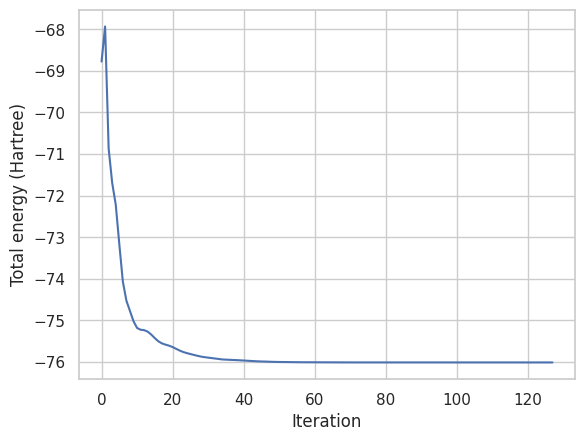

In [5]:
history = jnp.stack(history)
ax = sns.lineplot(history)
ax.set_xlabel("Iteration")
ax.set_ylabel("Total energy (Hartree)");